In [210]:
import torch
from torch import nn
from torch import optim

import pandas as pd
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [211]:
class CustomDataset(Dataset):

    def __init__(self, dataframe: pd.DataFrame, feature_names: list, target_name: str):
        scaler = StandardScaler()
        X = scaler.fit_transform(dataframe[feature_names])
        # X = dataframe[feature_names].values
        X = torch.tensor(X, dtype=torch.float32)
        
        self.X = X.reshape(X.shape[0], 1, X.shape[1])
        self.y = torch.tensor(dataframe[target_name].values, dtype=torch.float32)
        
    def __len__(self) -> int:
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [212]:
class FullyConnectedNet(nn.Module):

    def __init__(self, in_size: int, hidden_size: list, out_size: int):
        super(FullyConnectedNet, self).__init__()

        self.Network = nn.Sequential(
            nn.Flatten(),

            nn.Linear(in_size, hidden_size[0]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size[0]),

            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size[1]),

            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size[2]),

            nn.Linear(hidden_size[2], hidden_size[3]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size[3]),

            nn.Linear(hidden_size[3], hidden_size[4]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size[4]),

            nn.Linear(hidden_size[4], hidden_size[5]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size[5]),

            nn.Linear(hidden_size[5], hidden_size[6]),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size[6]),

            nn.Linear(hidden_size[6], out_size),
        )
    
    def forward(self, x):
        return self.Network(x)


In [213]:
df = pd.read_csv("data\df_01.csv", index_col=[0])
df = df.reset_index().drop(columns=['index'])

In [214]:
lithology_keys = {30000: 0,
                  65030: 1,
                  65000: 2,
                  80000: 3,
                  74000: 4,
                  70000: 5,
                  70032: 6,
                  88000: 7,
                  86000: 8,
                  99000: 9,
                  90000: 10,
                  93000: 11}

In [215]:
df['FORCE_2020_LITHOFACIES_LITHOLOGY'] = df['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(lithology_keys)

In [216]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_ecoded = encoder.fit_transform(df[['FORCE_2020_LITHOFACIES_LITHOLOGY']])
one_hot_df = pd.DataFrame(one_hot_ecoded, columns=encoder.get_feature_names_out())
df = pd.concat([df, one_hot_df], axis=1)

In [217]:
feature_names = ['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RMED', 'RDEP', 'RHOB',
                 'GR', 'NPHI', 'PEF', 'DTC', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'ROPA']

target_name = ['FORCE_2020_LITHOFACIES_LITHOLOGY_0', 'FORCE_2020_LITHOFACIES_LITHOLOGY_1', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_2', 'FORCE_2020_LITHOFACIES_LITHOLOGY_3',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_4', 'FORCE_2020_LITHOFACIES_LITHOLOGY_5',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_6', 'FORCE_2020_LITHOFACIES_LITHOLOGY_7', 
               'FORCE_2020_LITHOFACIES_LITHOLOGY_8', 'FORCE_2020_LITHOFACIES_LITHOLOGY_9',
               'FORCE_2020_LITHOFACIES_LITHOLOGY_10']

In [218]:
dataset = CustomDataset(dataframe=df, feature_names=feature_names, target_name=target_name)

train_, test = data.random_split(dataset, [0.8, 0.2])
train, val = data.random_split(train_, [0.7, 0.3])

In [219]:
train_data = DataLoader(dataset=train, batch_size=64, shuffle=True)
val_data = DataLoader(dataset=val, batch_size=64, shuffle=True)
test_data = DataLoader(dataset=test, batch_size=64, shuffle=False)

In [220]:
len(target_name)

11

In [221]:
model = FullyConnectedNet(in_size=len(feature_names), hidden_size=[863, 576, 435, 288, 144, 72, 36], out_size=len(target_name))
print(model)

FullyConnectedNet(
  (Network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18, out_features=863, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(863, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=863, out_features=576, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=576, out_features=435, bias=True)
    (8): ReLU()
    (9): BatchNorm1d(435, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=435, out_features=288, bias=True)
    (11): ReLU()
    (12): BatchNorm1d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Linear(in_features=288, out_features=144, bias=True)
    (14): ReLU()
    (15): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Linear(in_features=144, out_features=72, bias=True)
    (17

In [222]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01) # weight_decay=0.001
loss_function = nn.CrossEntropyLoss()

In [ ]:
epochs = 50
best_loss = 1e10 # заведомо высокое значение
loss_val = []
loss_train = []

for e in range(epochs):
    model.train()
    loss_mean = 0
    lm_count = 0

    train_tqdm = tqdm(train_data, leave=False)
    for x_train, y_train in train_tqdm:
        predict = model(x_train)
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f'Epoch [{e+1}/{epochs}], loss_mean={loss_mean:.3f} ')
    
    model.eval()
    Q_val = 0
    count_val = 0

    for x_val, y_val in val_data:
        with torch.no_grad():
            prediction = model(x_val)
            loss = loss_function(prediction, y_val)
            Q_val += loss.item()
            count_val += 1

    Q_val /= count_val

    loss_train.append(loss_mean)
    loss_val.append(Q_val)
    
    print(f' | loss_mean={loss_mean:.3f}, Q_val={Q_val:.3f}')




 | loss_mean=0.536, Q_val=0.396


 | loss_mean=0.394, Q_val=0.361


 | loss_mean=0.357, Q_val=0.359


 | loss_mean=0.338, Q_val=0.337


 | loss_mean=0.321, Q_val=0.298


 | loss_mean=0.306, Q_val=0.301


 | loss_mean=0.310, Q_val=3.515


 | loss_mean=0.299, Q_val=1.858


 | loss_mean=0.279, Q_val=1.307


 | loss_mean=0.273, Q_val=1.839


 | loss_mean=0.266, Q_val=2.363


 | loss_mean=0.266, Q_val=2.218


 | loss_mean=0.253, Q_val=5.177


 | loss_mean=0.246, Q_val=0.255


 | loss_mean=0.240, Q_val=0.247


 | loss_mean=0.235, Q_val=251553.683


 | loss_mean=0.237, Q_val=222684.484


 | loss_mean=0.228, Q_val=20657240.651


In [ ]:
Q = 0

In [ ]:
model.eval()

FullyConnectedNet(
  (Network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=18, out_features=576, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(576, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=576, out_features=435, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(435, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Linear(in_features=435, out_features=288, bias=True)
    (8): ReLU()
    (9): BatchNorm1d(288, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Linear(in_features=288, out_features=144, bias=True)
    (11): ReLU()
    (12): BatchNorm1d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Linear(in_features=144, out_features=72, bias=True)
    (14): ReLU()
    (15): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Linear(in_features=72, out_features=36, bias=True)
    (17): 

In [ ]:
predictions = []
tests = []
test_tqdm = tqdm(test_data, leave=True)
for x_test, y_test in test_tqdm:
    predict = model(x_test)
    predict = torch.argmax(predict, dim=1)
    y_test = torch.argmax(y_test, dim=1)
    predictions.extend(predict.cpu().detach().numpy().tolist())
    tests.extend(y_test.cpu().detach().numpy().tolist())
    Q += torch.sum(predict == y_test).item()

100%|██████████| 380/380 [00:10<00:00, 37.18it/s]


In [ ]:
Q /= len(test_data)
print(Q)

59.35263157894737


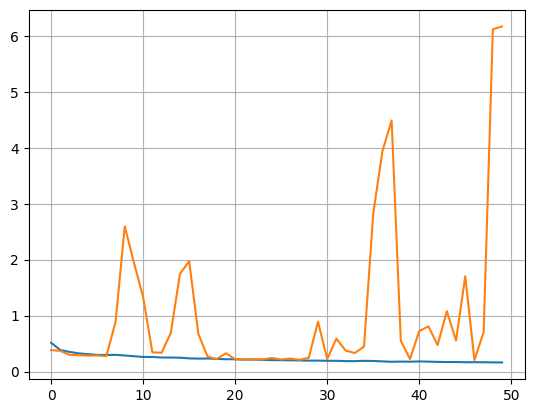

In [ ]:
plt.plot(loss_train)
plt.plot(loss_val)
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print(classification_report(tests, predictions))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3011
           1       0.80      0.80      0.80      2077
           2       0.96      0.97      0.96     13816
           3       0.93      0.83      0.88      1073
           4       0.61      0.60      0.61        50
           5       0.89      0.82      0.85      1732
           6       0.97      0.96      0.97       560
           7       0.99      1.00      1.00      1335
           8       0.90      0.74      0.81       125
           9       0.85      0.96      0.90       466
          10       0.60      0.74      0.67        39

    accuracy                           0.93     24284
   macro avg       0.85      0.85      0.85     24284
weighted avg       0.93      0.93      0.93     24284



<Axes: >

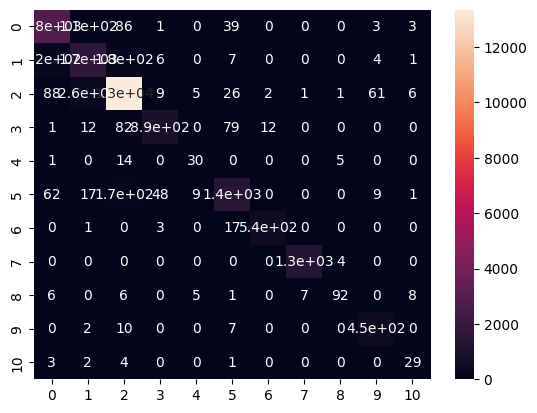

In [ ]:
cm = confusion_matrix(tests, predictions)
sns.heatmap(cm, annot=True)

In [ ]:
torch.save(model.state_dict(), 'models/fully_connected.tar')

In [ ]:
model_2 = FullyConnectedNet(in_size=len(feature_names), hidden_size=[576, 435, 288, 144, 72, 36], out_size=len(target_name))
state_dict = torch.load('models/fully_connected.tar', weights_only=True)
model_2.load_state_dict(state_dict)

<All keys matched successfully>